In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.table import Table
import os
from scipy.stats import sem
from matplotlib import gridspec
import matplotlib.font_manager as fm
font_path = 'Helvetica.ttf'
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)
font_name = font_prop.get_name()
plt.rcParams['font.family'] = font_name
font_size = 8
plt.rcParams['font.size'] = font_size

# Random extrapolation - across all train sizes

In [2]:
model_mapping = {
    'ft': 'ESM layer',
    'sae': 'SAE',
    'ft_logits': 'ESM logits'
}
width = 259.4769
height = 132.3491
pt = 1/72 
markersize = 5
linewidth=0.25

/tmp/ipykernel_3491349/2444843813.py:16: FutureWarning: The provided callable <function std at 0x7f67b84775b0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  grouped = df_filtered.groupby(["model", "train_size"])["test_p"].agg(["mean", np.std]).reset_index()
/tmp/ipykernel_3491349/2444843813.py:35: FutureWarning: The provided callable <function std at 0x7f67b84775b0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  grouped = filtered_df.groupby(["model", "train_size"])["test_p"].agg(["mean", np.std]).reset_index()


SAE 8     0.285612
9     0.418628
10    0.585113
11    0.666807
Name: mean, dtype: float64
ESM layer 0    0.266224
1    0.388489
2    0.551619
3    0.662670
Name: mean, dtype: float64
ESM logits 4    0.188542
5    0.307423
6    0.441553
7    0.547037
Name: mean, dtype: float64


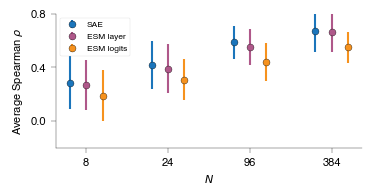

In [3]:
type = "learning_curve"
csv_paths = [
    f"results/DLG4_HUMAN_Faure_2021/probe_{type}_results.csv",
    f"results/F7YBW8_MESOW_Ding_2023/probe_{type}_results.csv",
    f"results/GFP_AEQVI_Sarkisyan_2016/probe_{type}_results.csv",
    f"results/GRB2_HUMAN_Faure_2021/probe_{type}_results.csv",
    f"results/SPG1_STRSG_Olson_2014/probe_{type}_results.csv",
    f"results/SPG1_STRSG_Wu_2016/probe_{type}_results.csv"
]

dfs = [pd.read_csv(path) for path in csv_paths]
full_df = pd.concat(dfs, ignore_index=True)
full_df['model'] = full_df['model'].replace(model_mapping)
filtered_df = full_df[full_df['train_size'].isin([8, 24, 96, 384])]
df_filtered = filtered_df[["train_size", "model", "test_p"]]
grouped = df_filtered.groupby(["model", "train_size"])["test_p"].agg(["mean", np.std]).reset_index()
grouped = grouped.rename(columns={'std': 'std_dev'})
models_to_plot = ['SAE', 'ESM layer', 'ESM logits']
colors = ['#1b75bb', '#af588a', '#f6921e']

fig = plt.figure(figsize=(width*pt, height*pt), constrained_layout=True)
gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1], figure=fig)
axs = fig.add_subplot(gs[0, 0])

dfs = [pd.read_csv(path) for path in csv_paths]
full_df = pd.concat(dfs, ignore_index=True)

# Rename models
full_df['model'] = full_df['model'].replace(model_mapping)

# get rid of any trainings that are not 8, 24, 96, or 384
train_sizes_to_plot = [8, 24, 96, 384]
filtered_df = full_df[full_df['train_size'].isin(train_sizes_to_plot)]

grouped = filtered_df.groupby(["model", "train_size"])["test_p"].agg(["mean", np.std]).reset_index()
grouped = grouped.rename(columns={'std': 'std_dev'})

models_to_plot = ['SAE', 'ESM layer', 'ESM logits']

offsets = np.linspace(-0.2, 0.2, len(models_to_plot))

for i, model in enumerate(models_to_plot):
    model_data = grouped[grouped['model'] == model]
    x_positions = np.arange(len(train_sizes_to_plot)) + offsets[i]
    
    axs.errorbar(
        x_positions,
        model_data['mean'],
        yerr=model_data['std_dev'],
        fmt='o', 
        label=model,
        color=colors[i],
        markersize=markersize,
        markeredgecolor='black',  
        markeredgewidth=linewidth,
    )

    print(model, model_data['mean'])

# Set labels and title
axs.set_xlabel(r"$N$")
axs.set_ylabel(r"Average Spearman $\rho$")
legend = axs.legend(fontsize=font_size-2)
legend.get_frame().set_linewidth(linewidth)
axs.tick_params(axis='both', labelsize=font_size, width=linewidth)
axs.set_xticks(np.arange(len(train_sizes_to_plot)))
axs.set_xticklabels(train_sizes_to_plot)
yticks = [0.0, 0.4, 0.8]
axs.set_yticks(yticks)
axs.set_yticklabels(yticks)
axs.set_ylim(-0.2, 0.8)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_linewidth(linewidth)
axs.spines['left'].set_linewidth(linewidth)
plt.savefig(f"learning_curve.pdf", dpi=300)

# Check weights of linear probe and compute percentage of weights active

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter

low_ns = [8, 24, 96, 384]
seeds = [0]
runs = [0]

# A list of the specific CSV files you want to analyze in each folder
file_names = [
    'model_sae.csv',
    'model_ft.csv',
    'model_ft_logits.csv'
]

type = "learning_curve"

# Store variance explained and weights + thresholds
all_explained_variances = {file_name: [] for file_name in file_names}
all_weights = {}
all_cutoffs = {file_name: [] for file_name in file_names}

# Find all top-level folders
top_level_folders = [f for f in os.listdir('results') 
                     if os.path.isdir(os.path.join('results', f))]
print("Starting analysis across multiple top-level result folders.")

for top_folder in top_level_folders:
    print(f"\n--- Processing folder: {top_folder} ---")
    
    for seed in seeds:
        for run in runs:
            for low_n in low_ns:
                base_path = os.path.join('results', top_folder, type)
                folder_path = os.path.join(base_path, f"probe_weights/seed{seed}_rerun{run}_train{low_n}")
                
                if not os.path.isdir(folder_path):
                    print(f"Skipping folder: {folder_path} (not found)")
                    continue
                
                for file_name in file_names:
                    file_path = os.path.join(folder_path, file_name)
                    
                    if not os.path.exists(file_path):
                        continue
                        
                    df = pd.read_csv(file_path)
                    weights = df['Weight'].values
                    
                    # Sort weights by absolute magnitude
                    sorted_weights = np.sort(np.abs(weights))[::-1]
                    
                    # Determine top 5% cutoff
                    top_k = max(1, int(0.05 * len(sorted_weights)))
                    cutoff_value = sorted_weights[top_k - 1]  # threshold magnitude
                    all_cutoffs[file_name].append(cutoff_value)
                    
                    top_weights = sorted_weights[:top_k]
                    if file_name not in all_weights: 
                        all_weights[file_name] = []
                    all_weights[file_name].extend(df['Weight'].tolist())
                    
                    # Variance explained = (sum of squares of top weights) / (sum of squares of all weights)
                    total_var = np.sum(weights ** 2)
                    top_var = np.sum(top_weights ** 2)
                    explained_ratio = (top_var / total_var) * 100 if total_var > 0 else 0.0
                    
                    all_explained_variances[file_name].append(explained_ratio)

# Consolidated analysis
print("\n" + "="*50)
print("Final Consolidated Analysis of Variance Explained by Top 5% Weights")
print("="*50)

avg_cutoffs = {}
for file_name, explained in all_explained_variances.items():
    if explained:
        mean_explained = np.mean(explained)
        std_explained = np.std(explained)
        avg_cutoffs[file_name] = np.mean(all_cutoffs[file_name])
        print(f"\nFile: {file_name}")
        print(f"Average % Variance Explained (Top 5% Weights): {mean_explained:.2f}%")
        print(f"Standard Deviation: {std_explained:.2f}%")
        print(f"Average cutoff magnitude for top 5%: {avg_cutoffs[file_name]:.4e}")
    else:
        print(f"\nNo data found for {file_name}")
        avg_cutoffs[file_name] = None

Starting analysis across multiple top-level result folders.

--- Processing folder: DLG4_HUMAN_Faure_2021 ---

--- Processing folder: F7YBW8_MESOW_Ding_2023 ---

--- Processing folder: GFP_AEQVI_Sarkisyan_2016 ---

--- Processing folder: GRB2_HUMAN_Faure_2021 ---

--- Processing folder: SPG1_STRSG_Olson_2014 ---

--- Processing folder: SPG1_STRSG_Wu_2016 ---

Final Consolidated Analysis of Variance Explained by Top 5% Weights

File: model_sae.csv
Average % Variance Explained (Top 5% Weights): 37.42%
Standard Deviation: 9.24%
Average cutoff magnitude for top 5%: 5.0325e-03

File: model_ft.csv
Average % Variance Explained (Top 5% Weights): 27.42%
Standard Deviation: 4.17%
Average cutoff magnitude for top 5%: 1.1919e-02

File: model_ft_logits.csv
Average % Variance Explained (Top 5% Weights): 25.02%
Standard Deviation: 12.03%
Average cutoff magnitude for top 5%: 7.5179e-01


## Full Histogram

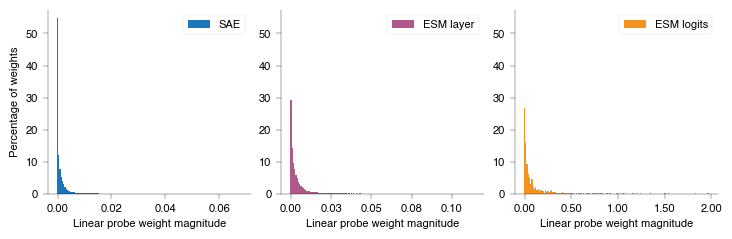

In [5]:
width = 518.74
height = 163.94
pt = 1/72  # 1 in to 72 pt
markersize = 5
linewidth = 0.25
font_size = 8
plt.rcParams['font.size'] = font_size

fig = plt.figure(figsize=(width*pt, height*pt), constrained_layout=True)
gs = gridspec.GridSpec(1, 3, height_ratios=[1], width_ratios=[1, 1, 1], figure=fig)
axs = [fig.add_subplot(gs[0, i]) for i in range(3)]
colors = ['#1B75BB', '#AF588A', '#F6921E']
labels = ['SAE', 'ESM layer', 'ESM logits']

for i, (file_name, label) in enumerate(zip(file_names, labels)):
    if file_name in all_weights:
        weights = np.array(all_weights[file_name])
        
        # Use absolute values
        filtered_weights = np.abs(weights[np.abs(weights) <= 3])
        # filtered_weights = np.abs(weights)
        
        # Histogram data
        hist_data, bin_edges = np.histogram(filtered_weights, bins=150, density=True)
        
        axs[i].bar(bin_edges[:-1], hist_data * np.diff(bin_edges) * 100,
                   width=np.diff(bin_edges), alpha=1, label=label, color=colors[i])
        
        # # Draw vertical line at average cutoff
        # if avg_cutoffs[file_name] is not None:
        #     axs[i].axvline(x=avg_cutoffs[file_name], color='k', linestyle='--', linewidth=linewidth)

# Set labels and styling
for i, (ax, label) in enumerate(zip(axs, labels)):
    ax.set_xlabel("Linear probe weight magnitude")
    if i == 0:
        ax.set_ylabel("Percentage of weights")
    else:
        ax.set_ylabel("")
    legend = ax.legend(fontsize=font_size, loc='upper right')
    legend.get_frame().set_linewidth(linewidth)
    ax.tick_params(axis='both', labelsize=font_size, width=linewidth)
    formatter = FuncFormatter(lambda y, _: f'{y:.2f}')
    ax.xaxis.set_major_formatter(formatter)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)

ylim_all = [ax.get_ylim() for ax in axs]
max_ylim = max([y[1] for y in ylim_all])
for ax in axs:
    ax.set_ylim(0, max_ylim)

plt.savefig("weights.pdf", dpi=300)

# Extrapolation over Low-N size 24

In [6]:
width = 178.2099
height = 132.1997

In [7]:
DMS_ids = [
    'GFP_AEQVI_Sarkisyan_2016', 'SPG1_STRSG_Olson_2014', 'SPG1_STRSG_Wu_2016', 
    'DLG4_HUMAN_Faure_2021', 'GRB2_HUMAN_Faure_2021', 'F7YBW8_MESOW_Ding_2023'
]
abbreviated_labels = []
for dms_id in DMS_ids:
    parts = dms_id.split('_')
    abbreviated_labels.append(f"{parts[0]} ({parts[2]})")
probe_types = ['learning_curve', 'mutation', 'position', 'regime', 'score']

for probe_type in probe_types:
    print(f"Generating plot for probe_type: {probe_type}")
    
    all_data_for_type = []
    
    # Loop through each DMS_id to collect data for the current probe_type
    for dms_id in DMS_ids:
        csv_path = f"results/{dms_id}/probe_{probe_type}_results.csv"
        
        try:
            df = pd.read_csv(csv_path)
            df['dms_id'] = dms_id # Add the DMS_id to the dataframe
            all_data_for_type.append(df)
            
        except FileNotFoundError:
            print(f"Warning: File not found for {csv_path}. Skipping.")
            continue
    
    if not all_data_for_type:
        print(f"No data found for probe_type: {probe_type}. Skipping plot generation.")
        continue
        
    full_df = pd.concat(all_data_for_type, ignore_index=True)
    
    # Rename models and filter for a specific train_size
    full_df['model'] = full_df['model'].replace(model_mapping)
    filtered_df = full_df[full_df['train_size'] == 24]
    
    # Group the filtered data to calculate mean and standard deviation for the error bars
    grouped = filtered_df.groupby(["model", "dms_id"])["test_p"].agg(["mean", np.std]).reset_index()
    grouped = grouped.rename(columns={'std': 'std_dev'})
    
    # --- Plot Generation ---
    fig = plt.figure(figsize=(width*pt, height*pt), constrained_layout=True)
    gs = gridspec.GridSpec(1, 1, figure=fig)
    axs = fig.add_subplot(gs[0, 0])

    offsets = np.linspace(-0.2, 0.2, len(models_to_plot))
    
    for i, model in enumerate(models_to_plot):
        model_data = grouped[grouped['model'] == model]
        # Ensure the data is in the same order as DMS_ids
        model_data = model_data.set_index('dms_id').reindex(DMS_ids).reset_index()
        
        x_positions = np.arange(len(DMS_ids)) + offsets[i]
        
        axs.errorbar(
            x_positions,
            model_data['mean'],
            yerr=model_data['std_dev'],
            fmt='o',
            label=model,
            color=colors[i],
            markersize=markersize,
            markeredgecolor='black',
            markeredgewidth=linewidth
        )
        
    axs.set_ylabel("Spearman ρ")
    yticks = [0.0, 0.4, 0.8]
    axs.set_yticks(yticks)
    axs.set_yticklabels(yticks)
    axs.set_ylim(-0.2, 0.8)
    axs.tick_params(axis='both', labelsize=font_size-2, width=linewidth)
    axs.set_xticks(np.arange(len(DMS_ids)))
    axs.set_xticklabels(abbreviated_labels, rotation=45, ha='right')
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.spines['bottom'].set_linewidth(linewidth)
    axs.spines['left'].set_linewidth(linewidth)
    plt.tight_layout()

    # Save the plot
    plt.savefig(f"probe_{probe_type}.pdf", dpi=300, bbox_inches='tight')
    plt.close(fig)



Generating plot for probe_type: learning_curve
Generating plot for probe_type: mutation


/tmp/ipykernel_3491349/4219020940.py:40: FutureWarning: The provided callable <function std at 0x7f67b84775b0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  grouped = filtered_df.groupby(["model", "dms_id"])["test_p"].agg(["mean", np.std]).reset_index()
/tmp/ipykernel_3491349/4219020940.py:81: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_3491349/4219020940.py:40: FutureWarning: The provided callable <function std at 0x7f67b84775b0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  grouped = filtered_df.groupby(["model", "dms_id"])["test_p"].agg(["mean", np.std]).reset_index()
/tmp/ipykernel_3491349/4219020940.py:81: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Generating plot for probe_type: position
Generating plot for probe_type: regime


/tmp/ipykernel_3491349/4219020940.py:40: FutureWarning: The provided callable <function std at 0x7f67b84775b0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  grouped = filtered_df.groupby(["model", "dms_id"])["test_p"].agg(["mean", np.std]).reset_index()
/tmp/ipykernel_3491349/4219020940.py:81: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_3491349/4219020940.py:40: FutureWarning: The provided callable <function std at 0x7f67b84775b0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  grouped = filtered_df.groupby(["model", "dms_id"])["test_p"].agg(["mean", np.std]).reset_index()
/tmp/ipykernel_3491349/4219020940.py:81: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykern

Generating plot for probe_type: score
